In [17]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from scipy import ndimage
from PIL import Image
from sklearn.cluster import KMeans
from sklearn import linear_model
import cv2


ModuleNotFoundError: No module named 'cv2'

In [3]:
# Helper functions
def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches

In [4]:
def rotation(orig, gts):
    ks=[90,180,270]
    rotated=[ndimage.rotate(img,k) for img in orig for k in ks]
    gt_rotated=[ndimage.rotate(gt_img,k) for gt_img in gts for k in ks]
    orig=orig+rotated
    gts=gts+gt_rotated
    print(len(orig))
    print(len(gts))
    return orig,gts

In [5]:
# Loaded a set of images
root_dir = "training/"
image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(60, len(files)) # Load maximum 20 images
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])

#imgs,gt_imgs=rotation(imgs,gt_imgs)

#n = 10 # Only use 10 images for training

Loading 60 images
satImage_001.png
Loading 60 images
satImage_001.png


In [221]:
imrot,gt_imrot=rotation(imgs,gt_imgs)

240
240


Image size = 400,400


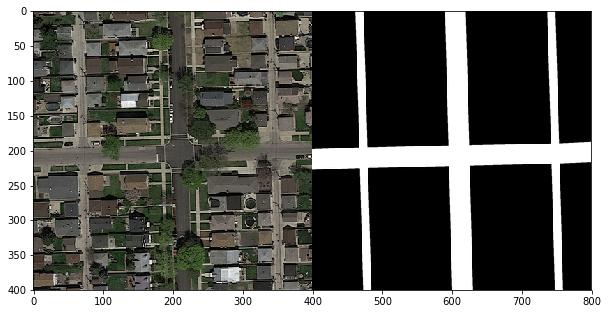

In [222]:
print('Image size = ' + str(imgs[0].shape[0]) + ',' + str(imgs[0].shape[1]))

# Show first image and its groundtruth image
cimg = concatenate_images(imgs[0], gt_imgs[0])
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')

In [6]:
# Extract patches from input images
patch_size = 10 # each patch is 16*16 pixels

img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(n)]
gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n)]

# Linearize list of patches
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])

In [7]:
# Extract 6-dimensional features consisting of average RGB color as well as variance
def extract_features(img):
    feat_m = np.mean(img, axis=(0,1))
    feat_v = np.var(img, axis=(0,1))
    feat = np.append(feat_m, feat_v)
    return feat

# Extract 2-dimensional features consisting of average gray color as well as variance
def extract_features_2d(img):
    feat_m = np.mean(img)
    feat_v = np.var(img)
    feat = np.append(feat_m, feat_v)
    return feat

# Extract features for a given image
def extract_img_features(filename):
    img = load_image(filename)
    img_patches = img_crop(img, patch_size, patch_size)
    X = np.asarray([ extract_features(img_patches[i]) for i in range(len(img_patches))])
    return X

In [ ]:
def 

In [225]:
# Compute features for each image patch
foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

def value_to_class(v):
    df = np.sum(v)
    if df > foreground_threshold:
        return 1
    else:
        return 0

X = np.asarray([ extract_features(img_patches[i]) for i in range(len(img_patches))])
Y = np.asarray([value_to_class(np.mean(gt_patches[i])) for i in range(len(gt_patches))])

In [226]:
# Print feature statistics

print('Computed ' + str(X.shape[0]) + ' features')
print('Feature dimension = ' + str(X.shape[1]))
print('Number of classes = ' + str(len(np.unique(Y))))  #TODO: fix, length(unique(Y)) 

Y0 = [i for i, j in enumerate(Y) if j == 0]
Y1 = [i for i, j in enumerate(Y) if j == 1]
print('Class 0: ' + str(len(Y0)) + ' samples')
print('Class 1: ' + str(len(Y1)) + ' samples')

Computed 96000 features
Feature dimension = 6
Number of classes = 2
Class 0: 74311 samples
Class 1: 21689 samples


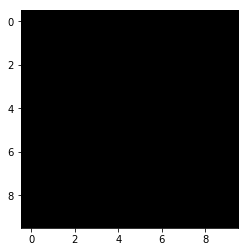

In [227]:
# Display a patch that belongs to the foreground class
plt.imshow(gt_patches[Y1[3]], cmap='Greys_r')

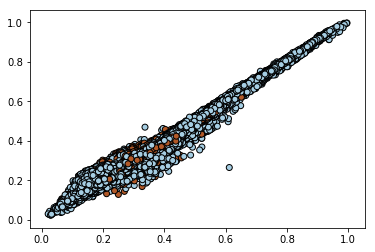

In [228]:
# Plot 2d features using groundtruth to color the datapoints
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired)

In [229]:
# train a logistic regression classifier
from sklearn import linear_model
logreg = linear_model.LogisticRegression(C=1e5, class_weight="balanced")
logreg.fit(X, Y)

LogisticRegression(C=100000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [ ]:
def compute_F1(Y,Z):
    TN = 0
    FP = 0
    FN = 0
    TP = 0
    matrix = []
    for i in range(len(Y)):
        if (Y[i]==0) & (Z[i]==0):
            TN = TN + 1
        elif (Y[i]==1) & (Z[i]==0):
            FN = FN + 1   
        elif (Y[i]==1) & (Z[i]==1):
            TP = TP + 1  
        else:
            FP = FP + 1

    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    return 2*precision*recall / (precision+recall) 

In [252]:
# Obtain train set
# Loaded a set of images
root_dir = "training/"
image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(75, len(files)) # Load maximum 20 images
imgs = [load_image(image_dir + files[i]) for i in range(n)]
gt_dir = root_dir + "groundtruth/"
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
imgs,gt_imgs = rotation(imgs,gt_imgs)

patch_size = 16 # each patch is 16*16 pixels
img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(len(imgs))]
gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(len(gt_imgs))]
img_patches = np.asarray([img_patches[i][j] 
                          for i in range(len(img_patches)) 
                          for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] 
                          for i in range(len(gt_patches)) 
                          for j in range(len(gt_patches[i]))])

X = np.asarray([ extract_features(img_patches[i]) for i in range(len(img_patches))])
Y = np.asarray([value_to_class(np.mean(gt_patches[i])) for i in range(len(gt_patches))])

300
300


In [253]:
logreg = linear_model.LogisticRegression(C=1e5, class_weight="balanced")
logreg.fit(X, Y)

LogisticRegression(C=100000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [254]:
# Predict on the training set
Z = logreg.predict(X)    
print('F1_score = ' + str(compute_F1(Y,Z)))

F1_score = 0.4538260767223057


In [255]:
# Obtain test set
root = "training/"
image_dir = root + "images/"
files = os.listdir(image_dir)
imgs_te = [load_image(image_dir + files[i]) for i in np.arange(n+1,len(files))]
gt_dir = root_dir + "groundtruth/"
gt_imgs_te = [load_image(gt_dir + files[i]) for i in np.arange(n+1,len(files))]

img_patches_te = [img_crop(imgs_te[i], patch_size, patch_size) for i in range(len(imgs_te))]
gt_patches_te = [img_crop(gt_imgs_te[i], patch_size, patch_size) for i in range(len(gt_imgs_te))]
img_patches_te = np.asarray([img_patches_te[i][j] 
                             for i in range(len(img_patches_te)) 
                             for j in range(len(img_patches_te[i]))])
gt_patches_te =  np.asarray([gt_patches_te[i][j] 
                             for i in range(len(gt_patches_te)) 
                             for j in range(len(gt_patches_te[i]))])
X_te = np.asarray([extract_features(img_patches_te[i]) for i in range(len(img_patches_te))])
Y_te = np.asarray([value_to_class(np.mean(gt_patches_te[i])) for i in range(len(gt_patches_te))])

Z_te = logreg.predict(X_te)
print('F1_score = ' + str(compute_F1(Y_te,Z_te)))

F1_score = 0.4540521305933635


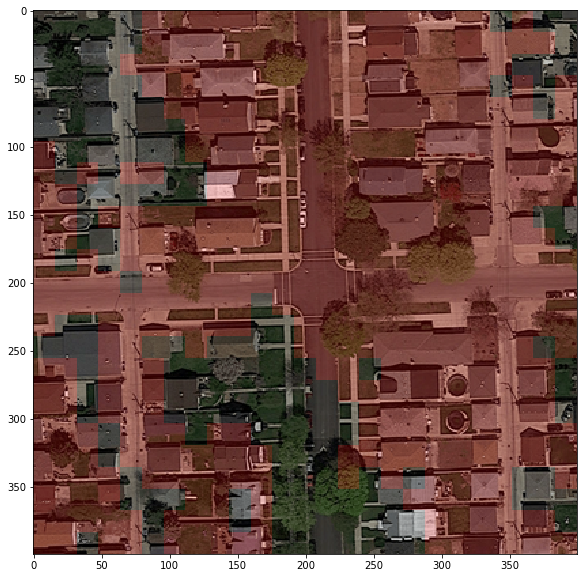

In [256]:
# Display prediction as an image
img_idx=0
w = gt_imgs_te[img_idx].shape[0]
h = gt_imgs_te[img_idx].shape[1]
predicted_im = label_to_img(w, h, patch_size, patch_size, Z_te)
cimg = concatenate_images(imgs[img_idx], predicted_im)
fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
plt.imshow(cimg, cmap='Greys_r')

new_img = make_img_overlay(imgs[img_idx], predicted_im)

plt.imshow(new_img)

In [160]:
# Plot features using predictions to color datapoints
plt.scatter(X[:, 0], X[:, 1], c=Z, edgecolors='k', cmap=plt.cm.Paired)

In [249]:
# Convert array of labels to an image

def label_to_img(imgwidth, imgheight, w, h, labels):
    im = np.zeros([imgwidth, imgheight])
    idx = 0
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            im[j:j+w, i:i+h] = labels[idx]
            idx = idx + 1
    return im

def make_img_overlay(img, predicted_img):
    w = img.shape[0]
    h = img.shape[1]
    color_mask = np.zeros((w, h, 3), dtype=np.uint8)
    color_mask[:,:,0] = predicted_img*255

    img8 = img_float_to_uint8(img)
    background = Image.fromarray(img8, 'RGB').convert("RGBA")
    overlay = Image.fromarray(color_mask, 'RGB').convert("RGBA")
    new_img = Image.blend(background, overlay, 0.2)
    return new_img
    

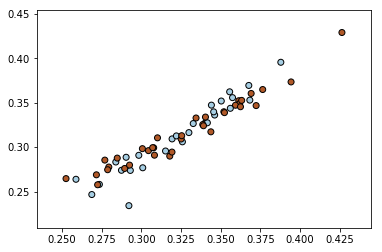

In [68]:
# Run prediction on the img_idx-th image
img_idx = 12

Xi = extract_img_features(image_dir + files[img_idx])
Zi = logreg.predict(Xi)
plt.scatter(Xi[:, 0], Xi[:, 1], c=Zi, edgecolors='k', cmap=plt.cm.Paired)

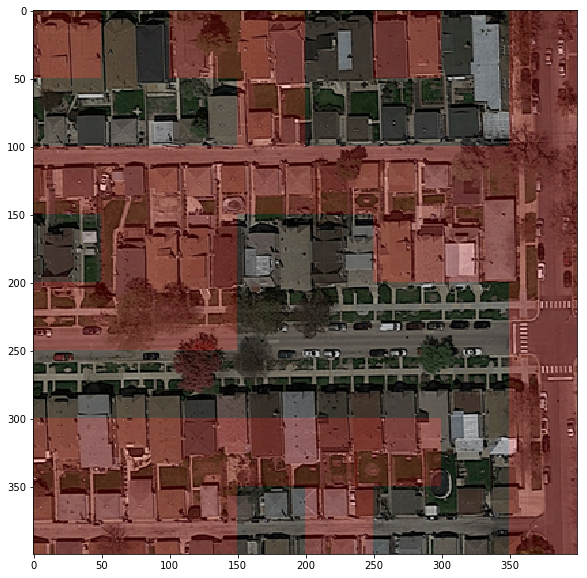

In [69]:
# Display prediction as an image

w = gt_imgs[img_idx].shape[0]
h = gt_imgs[img_idx].shape[1]
predicted_im = label_to_img(w, h, patch_size, patch_size, Zi)
cimg = concatenate_images(imgs[img_idx], predicted_im)
fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
plt.imshow(cimg, cmap='Greys_r')

new_img = make_img_overlay(imgs[img_idx], predicted_im)

plt.imshow(new_img)


In [17]:
def initialize_clusters(data, k):
    """initialize the k cluster centers (the means).
    input:
        data: original data with shape (num_sample, num_feature).
        k: predefined number of clusters for the k-means algorithm.
    output:
        a numpy array with shape (k, num_feature)
    """
    N,num_feature = data.shape

    n_el = int(N/k)
    centers = np.zeros((k,num_feature))
    cl = 0
    i = 0
    while i < N-n_el+1:
        total = np.zeros(num_feature)
        for j in range (n_el):
            total += data[i,:]
            i = i+1

        centers[cl,:] = total / n_el
        cl = cl+1
    return centers
        
def build_distance_matrix(data, mu):
    """build a distance matrix.
    return
        distance matrix:
            row of the matrix represents the data point,
            column of the matrix represents the k-th cluster.
    """
    N,k=data.shape
    distance = np.zeros((N,k))
    distance = (data**2).sum(axis=-1)[:, np.newaxis] + (mu**2).sum(axis=-1)
    distance -= 2 * np.squeeze(data.dot(mu[..., np.newaxis]), axis=-1)
    return distance

def update_kmeans_parameters(data, mu_old):
    """update the parameter of kmeans
    return:
        losses: loss of each data point with shape (num_samples, 1)
        assignments: assignments vector z with shape (num_samples, 1)
        mu: mean vector mu with shape (k, num_features)
    """

    distance = build_distance_matrix(data, mu_old)
    assignments = np.argmin(distance, axis=1)
    z = (distance == distance.min(axis=1)[:,None]).astype(int)
    mu = ((z.T.dot(data)).T/np.array(np.sum(z,axis=0))).T
    distance_new = build_distance_matrix(data, mu)
    losses = np.array((z * distance_new).max(axis=1))
    return losses,assignments,mu


In [18]:
def kmean_compression(X, k, max_iters, threshold):
    """using k-means for image compression."""
    # initialize the cluster.
    mu_old = initialize_clusters(X, k)
    # init some empty lists to store the result.
    loss_list = []

    # start the kmeans algorithm.
    for iter in range(max_iters):
        # update z and mu
        losses, assignments, mu = update_kmeans_parameters(X, mu_old)
        # calculate the average loss over all points
        average_loss = np.mean(losses)
        loss_list.append(average_loss)
        # check converge
        if iter > 0 and np.abs(loss_list[-1] - loss_list[-2]) < threshold:
            break
        # update k-means information.
        mu_old = mu
    return assignments
    
# plot histogram
# plot_image_compression(original_image, processed_image, assignments, mu, k)
# define parameters
k = 2
max_iter = 100
threshold = 1e-6
# use kmeans to compress image
assigns=kmean_compression(X, k, max_iter, threshold)
print(assigns)

# Get non-zeros in prediction and grountruth arrays
Zn = np.nonzero(assigns)[0]
Yn = np.nonzero(Y)[0]

TPR = len(list(set(Yn) & set(Zn))) / float(len(assigns))
print('True positive rate = ' + str(TPR))

[1 1 0 ... 1 1 1]
True positive rate = 0.1475


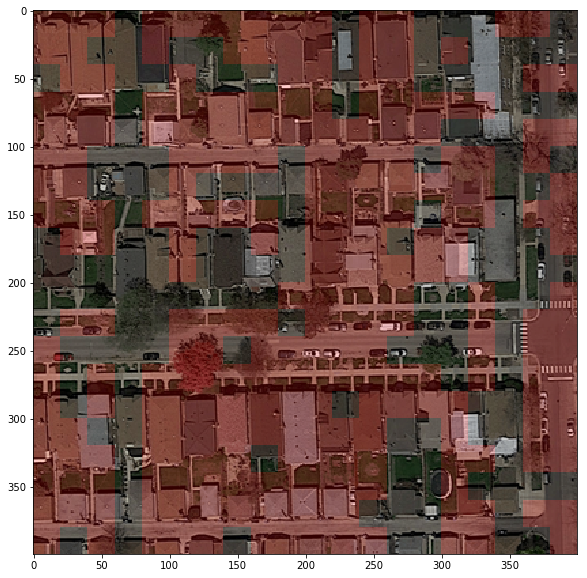

In [19]:
w = gt_imgs[img_idx].shape[0]
h = gt_imgs[img_idx].shape[1]
predicted_im = label_to_img(w, h, patch_size, patch_size, assigns)
cimg = concatenate_images(imgs[img_idx], predicted_im)
fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
plt.imshow(cimg, cmap='Greys_r')

new_img = make_img_overlay(imgs[img_idx], predicted_im)

plt.imshow(new_img)

# Running KMeans from Scikit

In [20]:
kmeans = KMeans(n_clusters=2, init='k-means++', random_state=0).fit(X)
kmeans.labels_

# Get non-zeros in prediction and grountruth arrays
Zn = np.nonzero(kmeans.labels_)[0]
Yn = np.nonzero(Y)[0]

TPR = len(list(set(Yn) & set(Zn))) / float(len(kmeans.labels_))
print('True positive rate = ' + str(TPR))

True positive rate = 0.15425


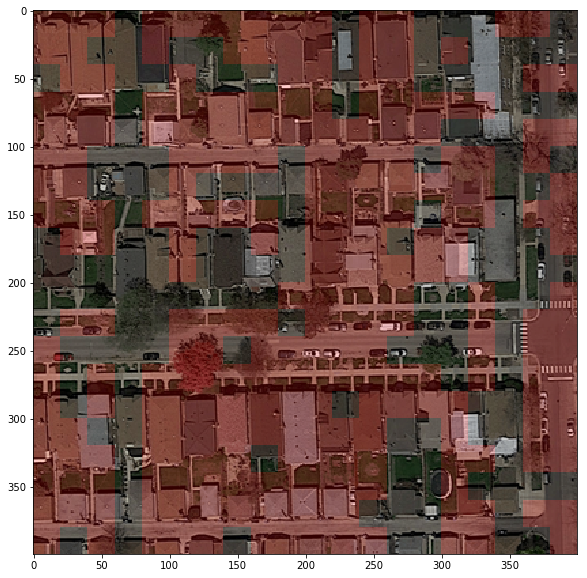

In [21]:
w = gt_imgs[img_idx].shape[0]
h = gt_imgs[img_idx].shape[1]
predicted_im = label_to_img(w, h, patch_size, patch_size, assigns)
cimg = concatenate_images(imgs[img_idx], predicted_im)
fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
plt.imshow(cimg, cmap='Greys_r')

new_img = make_img_overlay(imgs[img_idx], predicted_im)

plt.imshow(new_img)

# Training on multiple pictures

In [33]:
def single_image(img):
    # Extract patches from input images
    patch_size = 20 # each patch is 16*16 pixels

    img_patches = img_crop(img, patch_size, patch_size)
    img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
    X = np.asarray([ extract_features_2d(img) for i in range(len(img_patches))])
    
    kmeans = KMeans(n_clusters=2, init='k-means++', random_state=0).fit(X)

    return kmeans

In [47]:
# Loaded a set of images
root_dir = "training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(20, len(files)) # Load maximum 20 images
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])

models=[]
for img in imgs:
    models.append(single_image(img))
    

Loading 20 images
satImage_001.png
Loading 20 images
satImage_001.png


In [1]:
#obtain_result(load_image(image_dir+files[n+1]),load_image(gt_dir + files[n+1]),models)

In [46]:
def assign_label(patch,models):
    z=[]
    X=extract_features_2d(patch).reshape(1,-1)
    for mod in models:
        z.append(mod.predict(X))
    return 1*(np.mean(z)>0.5)

In [45]:
def obtain_result(img,gt_img,models):
    # Extract patches from input images
    patch_size = 20 # each patch is 16*16 pixels

    img_patches = img_crop(img, patch_size, patch_size)
    gt_patches = img_crop(gt_img, patch_size, patch_size)

    # Linearize list of patches
    img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
    gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])
    labels=[assign_label(img_patches[i][j],models) for i in range(len(img_patches)) for j in range(len(img_patches[i]))]
    Y = np.asarray([value_to_class(np.mean(gt_patches[i])) for i in range(len(gt_patches))])
    
    # Get non-zeros in prediction and grountruth arrays
    Zn = np.nonzero(labels)[0]
    Yn = np.nonzero(Y)[0]

    TPR = len(list(set(Yn) & set(Zn))) / float(len(labels))
    print('True positive rate = ' + str(TPR))
    
    return

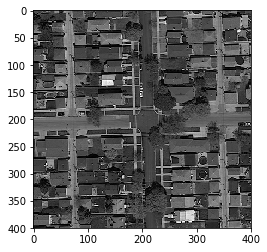

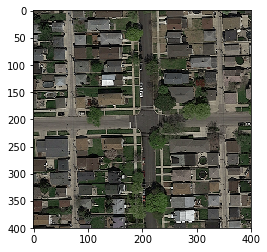

In [15]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

#img = mpimg.imread()     
gray = rgb2gray(imgs[0])    
plt.imshow(gray, cmap = plt.get_cmap('gray'))
plt.show()

plt.imshow(imgs[0], cmap = plt.get_cmap('gray'))
plt.show()

In [13]:
imgs[0][...,:3]  

array([[[0.33333334, 0.3019608 , 0.27058825],
        [0.31764707, 0.29411766, 0.2627451 ],
        [0.30588236, 0.28235295, 0.2509804 ],
        ...,
        [0.31764707, 0.3137255 , 0.29411766],
        [0.3019608 , 0.3019608 , 0.28627452],
        [0.30588236, 0.30588236, 0.2901961 ]],

       [[0.32156864, 0.2901961 , 0.2627451 ],
        [0.30588236, 0.28627452, 0.2509804 ],
        [0.3019608 , 0.28235295, 0.24313726],
        ...,
        [0.31764707, 0.31764707, 0.29803923],
        [0.3137255 , 0.3137255 , 0.2901961 ],
        [0.31764707, 0.32156864, 0.30588236]],

       [[0.3254902 , 0.3019608 , 0.27058825],
        [0.31764707, 0.28627452, 0.25490198],
        [0.3137255 , 0.2901961 , 0.25490198],
        ...,
        [0.31764707, 0.31764707, 0.29411766],
        [0.3137255 , 0.3137255 , 0.2901961 ],
        [0.31764707, 0.31764707, 0.3019608 ]],

       ...,

       [[0.02745098, 0.03137255, 0.01960784],
        [0.03529412, 0.03921569, 0.02745098],
        [0.05882353, 0

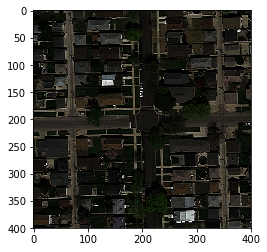

In [16]:
plt.imshow(imgs[0][...,:3]**2)
plt.show()

In [ ]:
gray_image = cv2.cvtColor(img[0], cv2.COLOR_BGR2GRAY)
one_layer_shape = [gray_image.shape[0], gray_image.shape[1], 1]
data_out = np.reshape(gray_image, one_layer_shape)
